In [0]:
import pandas as pd
import numpy as np
from gym.utils import seeding
import matplotlib.pyplot as plt

# Data import

In [0]:
import json
!kaggle config set -n path -v{/content}
!mkdir .kaggle
api_token ={"username":"skanderkaz","key":"80b99bdf67c3afd3b67c0129a46f2b5c"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs
!unzip \*.zip

In [0]:
data = pd.read_csv('Data/Stocks/goog.us.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2014-03-27 00:00:00 2017-11-10 00:00:00


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2014-03-27,568.00,568.00,552.92,558.46,13052,0
2014-03-28,561.20,566.43,558.67,559.99,41003,0
2014-03-31,566.89,567.00,556.93,556.97,10772,0
2014-04-01,558.71,568.45,558.71,567.16,7932,0
2014-04-02,599.99,604.83,562.19,567.00,146697,0


Text(0.5, 1.0, 'Real stock pice (Google)')

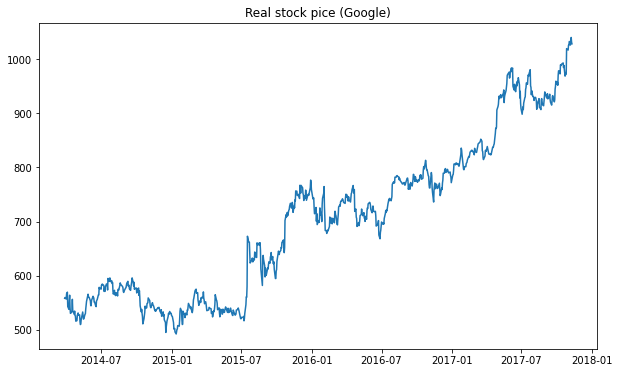

In [0]:
plt.figure(figsize=(10,6))
plt.plot(data['Close'])
plt.title('Real stock pice (Google)')

In [0]:
start_date = '2013-01-01'
date_split = '2016-01-01'
data_train = data[start_date:date_split]
data_test = data[date_split:]
len(data_train), len(data_test)


(446, 470)

# Environment

In [0]:
class tradingEnv:
  def __init__(self, data, time, initial_state=None, previous_price=None):
    self.data = data
    self.time = time
    self.seed()
    self.reset(initial_state, previous_price)

  def seed(self, seed=None):
    
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def reset(self, initial_state, previous_price):

    self.t = 0
    self.gains = []
    self.done=False
    self.previous_price = None

    if initial_state == None:
      self.prices = []
      for i in range(4):
        last_price = self.data.iloc[i, :]['Close']
        new_price = self.data.iloc[i+1, :]['Close']
        self.prices.append((new_price-last_price)/last_price)

      self.state = self.prices[-5:]
      self.t+=5
    else:
      self.prices = initial_state[:]
      self.state = initial_state[:]
    if previous_price is not None:
      self.previous_price = previous_price

  def step(self, act):
    
    #act=0: stay, -1 : sell, 1: buy

    if self.t==0:
      last_price = self.previous_price
    else:
      last_price = self.data.iloc[self.t-1, :]['Close']

    new_price = self.data.iloc[self.t, :]['Close']

    gain = (new_price-last_price)
    self.gains.append(act*gain)

    e = gain/last_price
    self.prices.append(e)

    reward = act*e - np.abs(act*0.00003)
    
    self.state = self.prices[-5:]
    self.t += 1

    if self.t == self.time :
      self.done = True

    return self.state, reward, self.done
  
  def get_last_state(self):
    last_prices = []
    for i in range(5,0,-1):
        last_price = self.data.iloc[self.time - i - 1, :]['Close']
        new_price = self.data.iloc[self.time - i, :]['Close']
        last_prices.append((new_price-last_price)/last_price)
    return last_prices

# Kernel RL algorithm + training

In [0]:
def kernel(y,x,bandwdith):

  m,_ = y.shape 
  kernels=np.exp(-0.5*np.power(np.linalg.norm(y-x,axis=1)/bandwdith, 2))
  kernels=kernels/np.sum(kernels)

  return kernels

In [0]:
def small_o(x,y,bandwidth):

  '''
  #x: is the begin state of the set of m transitions for an specific action
  #y: is the corresponding end state of the the set of m transtions for the 
  same action
  The output is the kernel computed for y vs x where the location (s',s) 
  corresponds to K(xs,ys')
  '''
  m,_=x.shape
  kernel_output=np.zeros((m,m))

  for i in range(m):
    kernel_output[i,:]=kernel(x,y[i],bandwidth)

  return kernel_output

In [0]:
def big_o(data_tensor,bandwidth):
  '''
  The "data_tensor" is an mxMx2xn where m is the number of transitions,
  M is the number of actions, 2 indicates that in each mxM there will be 2
  vectors, one x and one y. 'n' here indicates the dimensions of the vectors x 
  and y.
  '''
  m,M,_,_=data_tensor.shape
  O_out=np.zeros([m,M,m])
  for i in range(M):
    O_out[:,i,:]=small_o(data_tensor[:,i,0,:],data_tensor[:,i,1,:],bandwidth)
  return O_out

In [0]:
def kbrl_update_J(R,O,gamma,number_iterations):

  #gamma: discount_rate
  #R: mxM reward matrix with r(ys^a,xs,a) at (s,a)
  #O: m×M×m tensor with entry k(xs,ys'^a) at location (s',a,s)

  J_old=np.zeros(R.shape)
  for i in range(number_iterations):
    J_new=np.tensordot(O,R+gamma*J_old,axes=1)
    J_new=np.amax(J_new,1) #taking the maximum over the second axes
    J_old=J_new
  return J_new

In [0]:
def kbrl_optimization(bandwidth,gamma,number_iterations,data_tensor,R):
  O=big_o(data_tensor,bandwidth)
  J=kbrl_update_J(R,O,gamma,number_iterations)
  return O,J

In [0]:
def best_action_kbrl(J,R,data_tensor,gamma,bandwidth,x):

  #J:  mxM value function matrix
  #R: mxM reward matrix
  #gamma: discount factor

  m,M=J.shape
  kernel_x=np.zeros([m,M])
  for i in range(M):
    kernel_x[:,i]=kernel(data_tensor[:,i,0,:],x,bandwidth)
  q_tilde=np.multiply(kernel_x,R+gamma*J)
  q_tilde=np.sum(q_tilde,axis=0)
  best_action=np.argmax(q_tilde)-1
  return best_action

# Testing the algorithm

In [0]:
def get_transitions(data, time):
  transitions = []
  initial_state = []
  for i in range(5):
    last_price = data.iloc[i, :]['Close']
    new_price = data.iloc[i+1, :]['Close']
    initial_state.append((new_price-last_price)/last_price)

  prev_state = initial_state

  for i in range(1, time-5):
    new_state = []
    for j in range(5):
      last_price = data.iloc[i+j, :]['Close']
      new_price = data.iloc[i+j+1, :]['Close']
      new_state.append((new_price-last_price)/last_price)
    transitions.append([prev_state, new_state])
    prev_state = new_state
  return transitions

transitions = get_transitions(train, len(train))

In [0]:
L = 5
n_actions = 3
transitions = np.array(transitions)
data_tensor = np.zeros((transitions.shape[0],n_actions, 2, L))

data_tensor[:,0,:,:] = transitions
data_tensor[:,1,:,:] = transitions
data_tensor[:,2,:,:] = transitions

In [0]:
rewards = np.zeros((transitions.shape[0], n_actions))

for j, act in enumerate([-1,0,1]):
  env = tradingEnv(train, len(train))
  for i in range(transitions.shape[0]):
    _, reward, _ = env.step(act)
    rewards[i,j] = reward

In [0]:
gamma = 0.9
bandwidth = 0.01
n_iterations = 150

O, J = kbrl_optimization(bandwidth, gamma, n_iterations, data_tensor, rewards)

In [0]:
env = tradingEnv(train, len(train))
last_train_state = env.get_last_state()

In [0]:
testEnv = tradingEnv(test, len(test), last_train_state, previous_price=train['Close'][-1])

state = last_train_state

test_actions = []
test_rewards = []

for i in range(len(test)):
  best_action = best_action_kbrl(J, rewards, data_tensor, gamma, bandwidth, state)
  state, reward, _ = testEnv.step(best_action)
  test_actions.append(best_action)
  test_rewards.append(reward)

test_gains = testEnv.gains

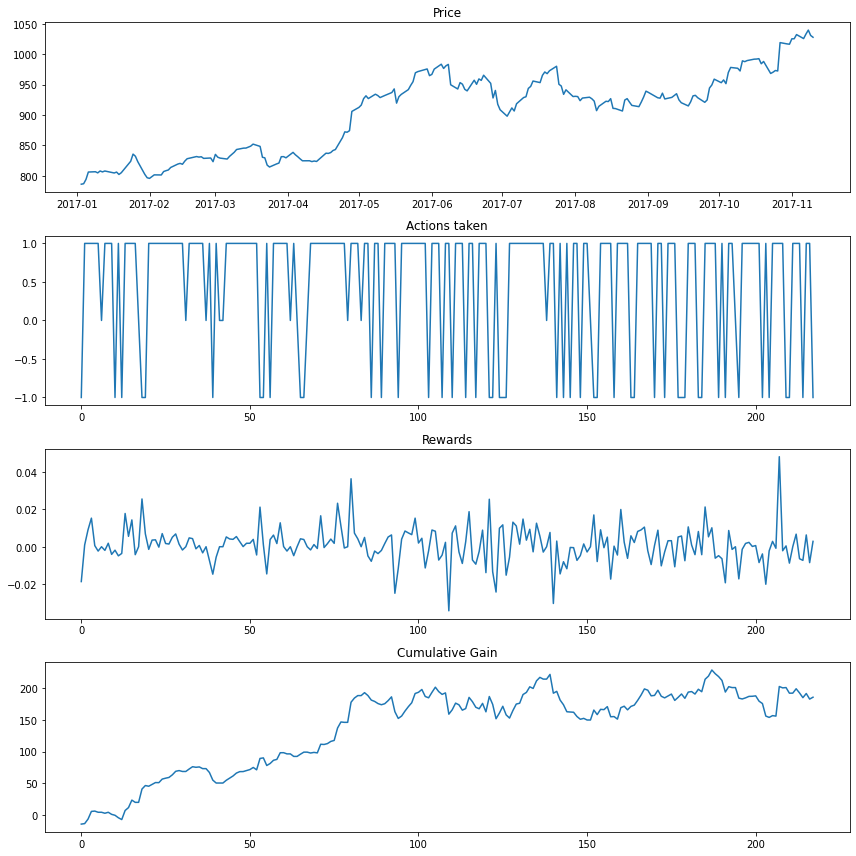

In [0]:
fig, ax = plt.subplots(4, 1, figsize=(12,12))

ax[0].plot(test['Close'])
ax[0].set_title('Price')
ax[1].plot(test_actions)
ax[1].set_title('Actions taken')
ax[2].plot(test_rewards)
ax[2].set_title('Rewards')
ax[3].plot(np.cumsum(test_gains))
ax[3].set_title('Cumulative Gain')

plt.tight_layout()

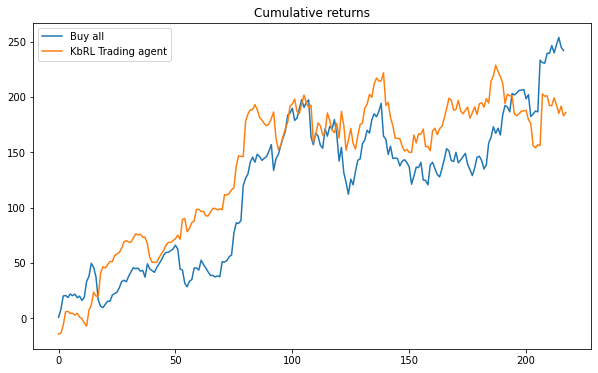

In [0]:
plt.figure(figsize=(10,6))
plt.title("Cumulative returns")
plt.plot(np.cumsum(np.diff(test['Close'])), label='Buy all')
plt.plot(np.cumsum(test_gains), label='KbRL Trading agent')
plt.legend()

In [0]:
print("Final return : {}".format(np.cumsum(test_gains)[-1]))

Final return : 185.81000000000085


# Another example (Amazon)

In [0]:
def train_and_test(data, date_split, gamma, bandwidth, n_iterations):

  train = data[:date_split]
  test = data[date_split:]

  transitions = get_transitions(train, len(train))


  L = 5
  n_actions = 3
  transitions = np.array(transitions)
  data_tensor = np.zeros((transitions.shape[0],n_actions, 2, L))

  data_tensor[:,0,:,:] = transitions
  data_tensor[:,1,:,:] = transitions
  data_tensor[:,2,:,:] = transitions

  rewards = np.zeros((transitions.shape[0], n_actions))

  for j, act in enumerate([-1,0,1]):
    env = tradingEnv(train, len(train))
    for i in range(transitions.shape[0]):
      _, reward, _ = env.step(act)
      rewards[i,j] = reward

  O, J = kbrl_optimization(bandwidth, gamma, n_iterations, data_tensor, rewards)

  env = tradingEnv(train, len(train))
  last_train_state = env.get_last_state()


  testEnv = tradingEnv(test, len(test), last_train_state, previous_price=train['Close'][-1])

  state = last_train_state

  test_actions = []
  test_rewards = []

  for i in range(len(test)):
    best_action = best_action_kbrl(J, rewards, data_tensor, gamma, bandwidth, state)
    state, reward, _ = testEnv.step(best_action)
    test_actions.append(best_action)
    test_rewards.append(reward)

  test_gains = testEnv.gains

  return train, test, test_actions, test_rewards, test_gains

In [0]:
data = pd.read_csv('Data/Stocks/amzn.us.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

Text(0.5, 1.0, 'Amazon stock price')

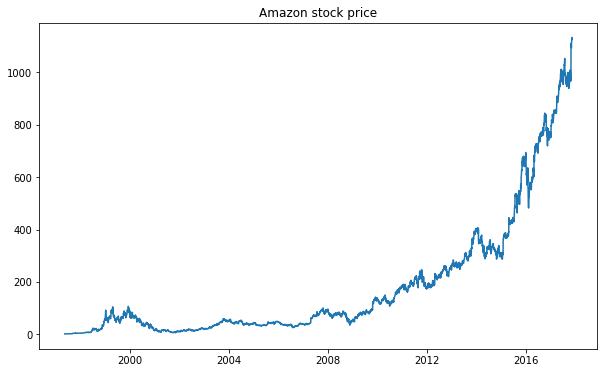

In [0]:
plt.figure(figsize=(10,6))
plt.plot(data['Close'])
plt.title("Amazon stock price")

In [0]:
date_split = '2013-12-31'

gamma = 0.9
bandwidth = 0.01
n_iterations = 50

train, test, test_actions, test_rewards, test_gains = train_and_test(data, date_split, gamma, bandwidth, n_iterations)

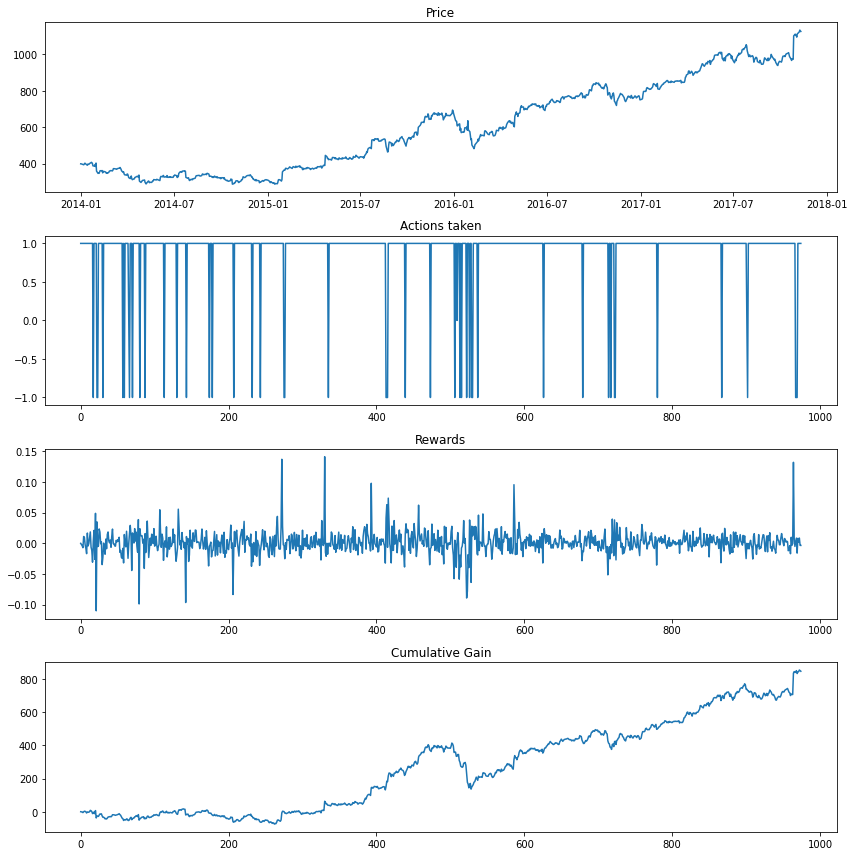

In [0]:
fig, ax = plt.subplots(4, 1, figsize=(12,12))

ax[0].plot(test['Close'])
ax[0].set_title('Price')
ax[1].plot(test_actions)
ax[1].set_title('Actions taken')
ax[2].plot(test_rewards)
ax[2].set_title('Rewards')
ax[3].plot(np.cumsum(test_gains))
ax[3].set_title('Cumulative Gain')

plt.tight_layout()

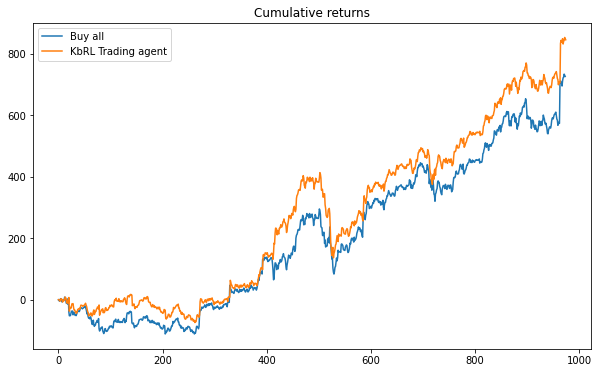

In [0]:
plt.figure(figsize=(10,6))
plt.title("Cumulative returns")
plt.plot(np.cumsum(np.diff(test['Close'])), label='Buy all')
plt.plot(np.cumsum(test_gains), label='KbRL Trading agent')
plt.legend()

In [0]:
print("Final return : {}".format(np.cumsum(test_gains)[-1]))

Final return : 845.9700000000003
